## Import modules

In [1]:
from common_dirs_fns import *
from sort_seq_functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Specify matplotlib formatting
%matplotlib inline
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.
mpl.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 7})

## Import and process peptide count dataframe

In [3]:
# Import tln_count_df, which was generated in NGS_data
tln_count_df = pd.read_csv(analysis_path+'tln_count_df.csv',index_col=[0,1],header=[0,1],na_filter=False)

In [4]:
# Process tln_count_df
tln_count_df_processed = process_tln_count_df(tln_count_df)
tln_count_df_processed.to_csv(analysis_path+'tln_count_df_processed.csv')

## Fit lognormal distributions to read data

In [5]:
# Fit lognormal distributions and calculate statistics for tln_count_df_processed
# Only fit peptides with > 10 reads total across all bins (Bins 1-8)
minimum_reads = 10
stats_table = make_stats_table(tln_count_df_processed[tln_count_df_processed['TotalReads']>minimum_reads],
                              analysis_path+'stats_table.csv',
                              upper, lower, 'LogNorm')

C:\Users\Kathryn\Documents\GitHub\PhoPQ_hAMP_sort-seq\sort_seq_functions.py:41: RuntimeWarning: divide by zero encountered in log
  return -1.*sum((r)*np.log(lognorm_cdf(upper, mu, sigma)-lognorm_cdf(lower, mu, sigma)))
C:\Users\Kathryn\Documents\GitHub\PhoPQ_hAMP_sort-seq\sort_seq_functions.py:41: RuntimeWarning: invalid value encountered in double_scalars
  return -1.*sum((r)*np.log(lognorm_cdf(upper, mu, sigma)-lognorm_cdf(lower, mu, sigma)))
C:\Users\Kathryn\Documents\GitHub\PhoPQ_hAMP_sort-seq\sort_seq_functions.py:41: RuntimeWarning: invalid value encountered in multiply
  return -1.*sum((r)*np.log(lognorm_cdf(upper, mu, sigma)-lognorm_cdf(lower, mu, sigma)))
C:\Users\Kathryn\Documents\GitHub\PhoPQ_hAMP_sort-seq\sort_seq_functions.py:36: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5*(1+erf((np.log(x)-mu)/(sigma*np.sqrt(2))))
C:\Users\Kathryn\Documents\GitHub\PhoPQ_hAMP_sort-seq\sort_seq_functions.py:41: RuntimeWarning: invalid value encountered in log
  r

## Analyze fits

In [6]:
# Add assigned peptide data to stats_table
stats_table['AssignedPeptide'] = tln_count_df_processed.loc[stats_table.index,'AssignedPeptide']

In [7]:
# Print success rate among all peptides
success_counter = Counter(stats_table.loc[:,'Success'])

print('\t\t'.join(['Number of successful fits:\t',
      str(success_counter[True]),
      '{:.2%}'.format(success_counter[True]/len(stats_table))]))

print('\t\t'.join(['Number of failed fits:\t\t',
      str(success_counter[False]),
      '{:.2%}'.format(success_counter[False]/len(stats_table))]))

print('*************')

# Print success rate for human AMPs in library
hAMP_success_counter = Counter(stats_table.loc[~stats_table['AssignedPeptide'].isin(['','*']),'Success'])

print('\t\t'.join(['Number of successful human AMP fits:',
      str(hAMP_success_counter[True]),
      '{:.2%}'.format(hAMP_success_counter[True]/len(stats_table.loc[~stats_table['AssignedPeptide'].isin(['','*'])]))]))

print('\t\t'.join(['Number of failed human AMP fits:',
      str(hAMP_success_counter[False]),
      '{:.2%}'.format(hAMP_success_counter[False]/len(stats_table.loc[~stats_table['AssignedPeptide'].isin(['','*'])]))]))


Number of successful fits:			12767		93.58%
Number of failed fits:				876		6.42%
*************
Number of successful human AMP fits:		117		100.00%
Number of failed human AMP fits:		0		0.00%


## Plot fluorescence and fold change distributions

### Compare initial and final parameter (mu, sigma) values

Both "Simple" (initial) and "Lognorm" (final) assume a lognormal distribution. Simple uses the bin centers in log space to estimate mu and sigma, and then calculates mean using the formula exp(mu + sigma^2/2). Lognorm uses the mu and sigma calculated from Simple as inputs to a minimization function to find a best-fit lognormal distribution for a given peptide.

Simple and Lognorm fits correspond very closely. From here forward all data will be analyzed based on Simple because:
- Some peptides were not successfully fit using Lognorm (~6%)
- Simple is faster computationally, which will be useful for bootstrapping

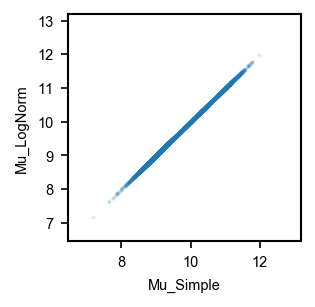

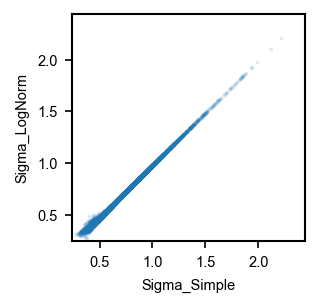

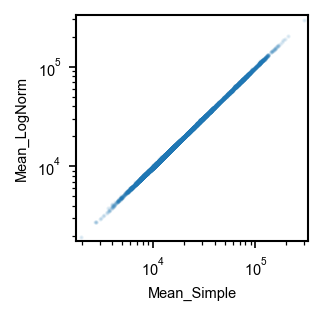

In [8]:
for param in ['Mu','Sigma','Mean']:
    fig = plt.figure(figsize=(2,2),dpi=150)
    plt.plot(stats_table.loc[stats_table['Success'], param+'_Simple'],
                    stats_table.loc[stats_table['Success'], param+'_LogNorm'],
                    linestyle='', marker='.', markersize=2, alpha=0.1)
    
    if param == 'Mean':
        plt.xscale('log')
        plt.yscale('log')
    
    axis_min = min(stats_table.loc[stats_table['Success'], param+'_Simple'].min(),
                   stats_table.loc[stats_table['Success'], param+'_LogNorm'].min())*0.9
    
    axis_max = max(stats_table.loc[stats_table['Success'], param+'_Simple'].max(),
                   stats_table.loc[stats_table['Success'], param+'_LogNorm'].max())*1.1
    
    plt.xlim([axis_min,axis_max])
    plt.ylim([axis_min,axis_max])
    
    plt.xlabel(param+'_Simple')
    plt.ylabel(param+'_LogNorm')
    plt.show()

## Generate plots of histograms for control strains

In [9]:
# Import human AMP data scraped from APD3 (Antimicrobial Peptide Database 3)
peptide_df = pd.read_excel('human_AMPs.xlsx',index_col=0)

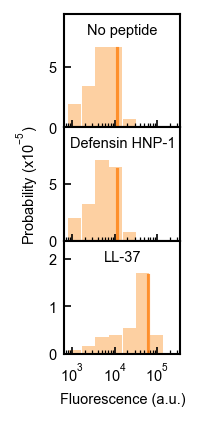

In [10]:
fig = plt.figure(figsize=(1., 3.), dpi=150)
gs = mpl.gridspec.GridSpec(3, 1, hspace=0.)

control_peptides = ['*',
                    peptide_df.set_index('SimpleName').loc['human neutrophil peptide-1','Sequence'],
                    peptide_df.set_index('SimpleName').loc['LL-37','Sequence']
                    ]

titles = ['No peptide', 'Defensin HNP-1', 'LL-37']

scaling = 10**5

for i,peptide in enumerate(control_peptides):
    ax = fig.add_subplot(gs[i])
    
    heights = tln_count_df_processed.loc[peptide, (mixed_stats_bins.index,'BinNorm')]*scaling
    bw = mixed_stats_bins['BinWidth']
    ax.bar(lower, height=heights, width=bw, align='edge', color='#fdd0a2')
    
    y_ax_max = max(heights)*1.4
    ax.set_ylim([0, y_ax_max])
    
    mean_value = stats_table.loc[peptide,'Mean_Simple']
    y_mean_max = heights.iloc[np.argmax(lower>mean_value)-1]
    ax.axvline(mean_value,
               ymax = y_mean_max/y_ax_max*0.98,
               color='C1',
               alpha=0.8,
               linewidth=1.5)
    
    plt.xscale('log')
    ax_lims = [lower[0]/1.2, upper[-1]*1.2]
    ax.set_xlim(ax_lims)
    
    ax.tick_params(axis='both',direction="in", which='both')
    
    locmaj = mpl.ticker.LogLocator(base=10., numticks=7)
    locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
                                              numticks=7)
    ax.xaxis.set_major_locator(locmaj)
    ax.xaxis.set_minor_locator(locmin)
    
    if i < 2:
        ax.xaxis.set_ticklabels([])
    
    if i == 2:
        ax.set_xlabel('Fluorescence (a.u.)')
    
    if i == 1:
        ax.set_ylabel('Probability '+r'(x$10^{-5}$)')
    
    ax.text(0.5, 0.92, titles[i], size=7,
            horizontalalignment='center',
            verticalalignment='top',
            transform=ax.transAxes)
    

plt.savefig(figures_path+'control_histograms_no_fit.png', bbox_inches='tight', dpi=300)
plt.savefig(figures_path+'control_histograms_no_fit.svg', bbox_inches='tight', dpi=300)